## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

from utils.preprocessing import df_to_xydf, df_to_xy

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
df = df.dropna()

In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prop,179.0,92.765363,28.240156,10.0,85.0,100.0,100.0,200.0
other_resp,179.0,78.156425,28.008989,5.0,50.0,80.0,100.0,190.0
other_prop,179.0,79.525140,32.652807,0.0,50.0,80.0,100.0,190.0
time_spent_risk,179.0,45955.307263,29132.942323,0.0,26000.0,39000.0,60000.0,152000.0
cells,179.0,27.340782,16.082689,1.0,12.0,22.0,48.5,50.0
selfish,179.0,28.379888,19.940948,0.0,12.5,30.0,45.0,60.0
time_spent_prop,179.0,53273.743017,29945.417255,16000.0,35500.0,47000.0,60500.0,269000.0
count_effort,179.0,13.273743,5.305068,0.0,9.0,14.0,18.0,20.0
Honesty_Humility,179.0,3.503352,0.556564,1.9,3.1,3.5,3.9,4.9
Extraversion,179.0,3.307821,0.720366,1.1,2.9,3.4,3.8,4.8


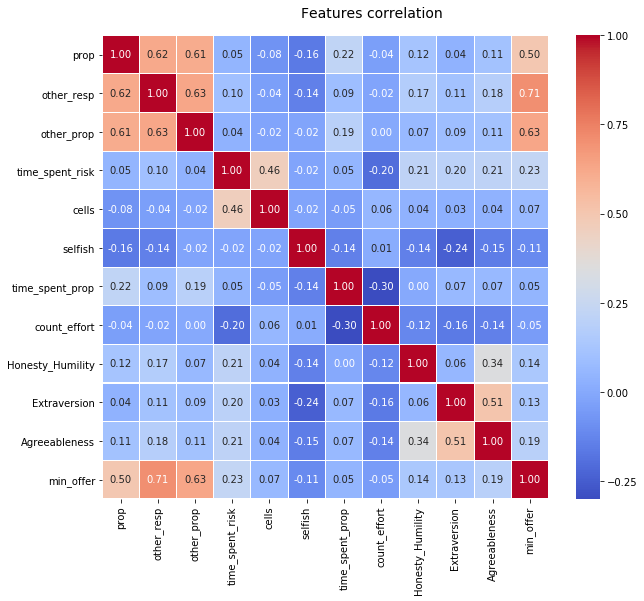

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 8))
df_x, df_y = df_to_xydf(df)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']
corr = df_corr.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Features correlation', fontsize=14)

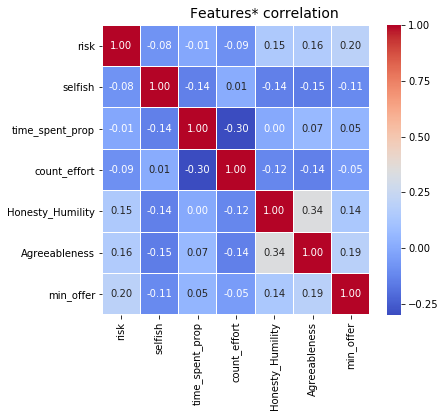

In [4]:

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(6, 5))
df_x, df_y = df_to_xydf(
    df=df,
    select_columns=['risk', 'selfish', 'time_spent_prop', 'count_effort', 'Honesty_Humility', 'Agreeableness'],
    fuse_risk=True,
)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']
corr = df_corr.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Features* correlation', fontsize=14)

**Pair plots**

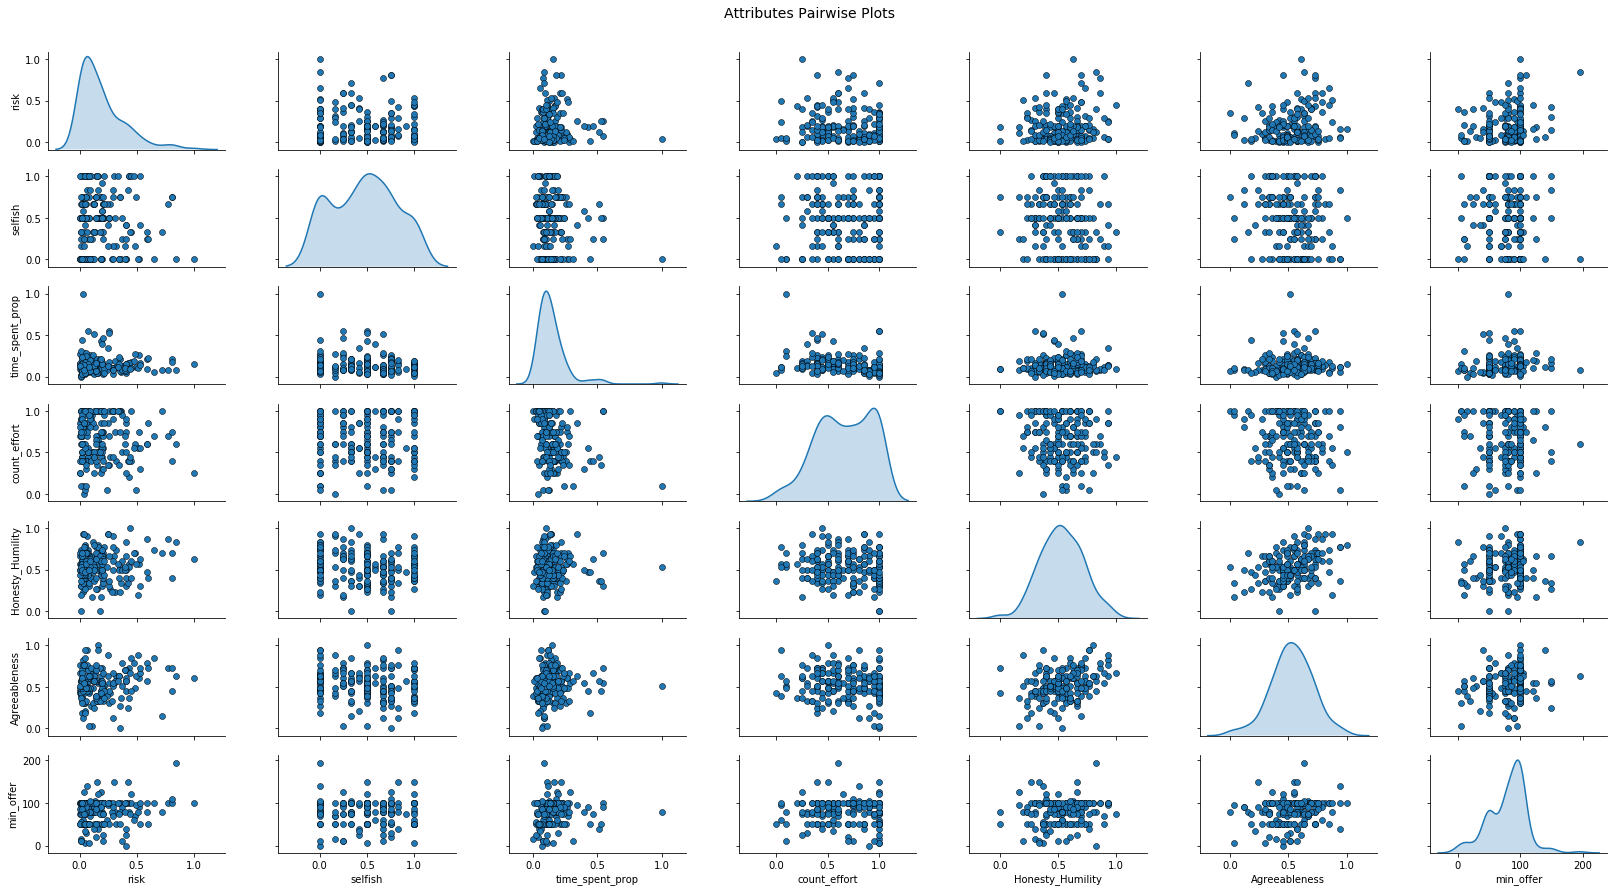

In [5]:
#cols = ['density', 'residual sugar', 'total sulfur dioxide', 'fixed acidity']
pp = sns.pairplot(df_corr, height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Attributes Pairwise Plots', fontsize=14)

**Target distribution**

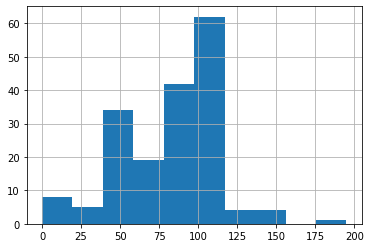

In [6]:
df['min_offer'].hist()

**Proposer offer distribution**

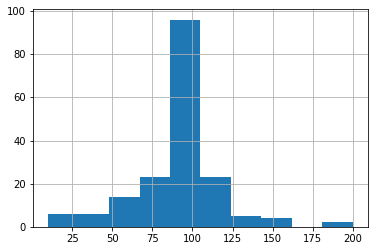

In [7]:
df['prop'].hist()

In [8]:
from models.metrics import cross_compute, avg_gain_ratio, gain, gain_mean

print("human avg_gain_ratio", cross_compute(df['min_offer'], df['prop'], avg_gain_ratio))
print("human mean gain", round(cross_compute(df['min_offer'], df['prop'], gain_mean)))

human avg_loss_ratio 0.7384905823683424
human mean gain 89.0


**Responder offer distribution**

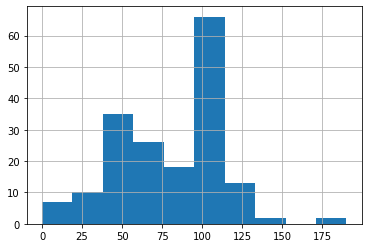

In [9]:
df['other_prop'].hist()

In [10]:
from models.metrics import cross_compute, avg_gain_ratio, gain, gain_mean

print("human avg_gain_ratio", cross_compute(df['min_offer'], df['other_prop'], avg_gain_ratio))
print("human mean gain", round(cross_compute(df['min_offer'], df['other_prop'], gain_mean)))

human avg_loss_ratio 0.5772941215657953
human mean gain 70.0
